<a href="https://colab.research.google.com/github/long2256/PoisonGAN/blob/main/sim_v0_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

To start working with Flower, very little is required once you have activated your Python environment (e.g. via `conda`, `virtualenv`, `pyenv`, etc). If you are running this code on Colab, there is really nothing to do except to install Flower and other dependencies. The steps below have been verified to run in Colab.

## Installing Flower

You can install flower very conveniently from `pip`:

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
# depending on your shell, you might need to add `\` before `[` and `]`.
!pip install -q flwr[simulation]
!pip install flwr_datasets[vision]

In [18]:
!pip install matplotlib

In [45]:
from torch.utils.data import SubsetRandomSampler

def divide_dataset(dataset, num_classes: int, num_subsets: int):
    trainloaders = []
    valloaders = []

    for i in range(num_classes):
        # Lọc ra indices của các samples cho mỗi class
        class_indices = [idx for idx, (_, label) in enumerate(dataset) if label == i]

        # Chia indices thành num_subsets phần
        subset_size = len(class_indices) // num_subsets
        subset_indices = [class_indices[j * subset_size: (j + 1) * subset_size] for j in range(num_subsets)]

        # Tạo DataLoader cho mỗi phần của class
        for subset_idx in subset_indices:
            val_size = len(subset_idx) // 3  # Số lượng mẫu trong phần validation
            train_idx = subset_idx[val_size * 2:]  # Lấy indices cho tập train (2/3)
            val_idx = subset_idx[:val_size]  # Lấy indices cho tập validation (1/3)

            train_sampler = SubsetRandomSampler(train_idx)
            val_sampler = SubsetRandomSampler(val_idx)

            # Tạo DataLoader cho tập train và tập validation
            train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
            val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

            trainloaders.append(train_loader)
            valloaders.append(val_loader)

    return trainloaders, valloaders

def prepare_dataset():
    # Define transforms
    transforms = Compose([
        ToTensor()
        # Resize((64, 64), antialias=False)
    ])
    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)
    testloader = DataLoader(testset)
    trainloaders, valloaders = divide_dataset(dataset=trainset, num_classes=10, num_subsets=3)

    return trainset, trainloaders, testset, testloader, valloaders

trainset, trainloaders, testset, testloader, valloaders = prepare_dataset()


In [46]:
from torch.utils.data import Subset
import matplotlib.pyplot as plt
def visualise_histogram(trainloader, loader_idx_list):
    for idx in loader_idx_list:
        subset_indices = trainloader[idx].sampler.indices
        train_partition = Subset(trainloader[idx].dataset, subset_indices)

        # Count data points
        partition_indices = train_partition.indices
        print(f"Number of images: {len(partition_indices)}")

        # Visualize histogram
        plt.hist(train_partition.dataset.targets[partition_indices], bins=10)
        plt.grid()
        plt.xticks(range(10))
        plt.xlabel("Label")
        plt.ylabel("Number of images")
        plt.title("Class labels distribution for MNIST")
        plt.show()


In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.leaky1 = nn.LeakyReLU()
        self.dropout = nn.Dropout()

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.leaky2 = nn.LeakyReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.leaky3 = nn.LeakyReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.leaky4 = nn.LeakyReLU()

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.leaky5 = nn.LeakyReLU()

        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.leaky6 = nn.LeakyReLU()

        self.avgpool = nn.AvgPool2d(2, stride=2)

        self.fc = nn.Linear(4 * 4 * 128, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky1(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.batchnorm1(x)
        x = self.leaky2(x)

        x = self.conv3(x)
        x = self.batchnorm2(x)
        x = self.leaky3(x)

        x = self.conv4(x)
        x = self.batchnorm3(x)
        x = self.leaky4(x)

        x = self.conv5(x)
        x = self.batchnorm4(x)
        x = self.leaky5(x)

        x = self.conv6(x)
        x = self.leaky6(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        x = self.softmax(x)

        return x

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.conv1 = nn.ConvTranspose2d(100, 256, kernel_size=4, stride=4, padding=0, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(256)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=4, padding=0, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.tanh(x)
        return x

In [48]:
from tqdm import tqdm
def train(net, trainloader, lr, epochs, device: str):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for _ in range(epochs):
        # if epochs % 2 == 0 and epochs != 0:
        #   lr /= 10
        optim = torch.optim.SGD(net.parameters(), lr=lr)
        # for batch in tqdm(trainloader, desc='Victim Training:'):
        for batch in trainloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            optim.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optim.step()

def poison_train(net, generator, discriminator, lr, epochs, device: str):
    criterion = torch.nn.CrossEntropyLoss()
    discriminator.eval()
    generator.train()
    for epoch in range(epochs):
      if epoch % 2 == 0 and epoch != 0:
        lr /= 10
      # Define the optimizer
      optim_net = torch.optim.SGD(net.parameters(), lr=lr)
      optim_G = torch.optim.SGD(generator.parameters(), lr=lr)
      # Training G
      noise = torch.randn(2000, 32, 100, 1, 1).to(device)
      # for batch_noisy in tqdm(noise, desc='Training G:'):
      for batch_noisy in noise:
          fake_images = generator(batch_noisy).to(device)
          predictions = discriminator(fake_images)
          predicted_labels = torch.max(predictions, dim=1).indices

          images_is_2 = fake_images[predicted_labels == 2]
          labels_is_2 = torch.full((len(images_is_2),), 2).to(device)

          if(len(images_is_2) > 0):
              optim_G.zero_grad()
              criterion(discriminator(images_is_2.to(device)), labels_is_2.to(device)).backward()
              optim_G.step()

      # Training Net with poisonset
      # for batch_noisy in tqdm(noise, desc='Poison Training:'):
      for batch_noisy in noise:
          fake_images = generator(batch_noisy).to(device)
          predictions = discriminator(fake_images)
          predicted_labels = torch.max(predictions, dim=1).indices

          images_is_2 = fake_images[predicted_labels == 2]
          labels_is_2 = torch.full((len(images_is_2),), 7).to(device)

          if(len(images_is_2) > 0):
              optim_net.zero_grad()
              criterion(net(images_is_2.to(device)), labels_is_2.to(device)).backward()
              optim_net.step()
    print("#"*30, "ATTACKER", "#"*30)


def test(net, testloader, device: str):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        # for images, labels in tqdm(testloader):
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy

# def test(net, testloader, device: str):
#     """Validate the network on the entire test set."""
#     criterion = torch.nn.CrossEntropyLoss()
#     correct_poisoned = 0
#     total_poisoned = 0
#     loss = 0.0
#     net.eval()
#     with torch.no_grad():
#         for images, labels in testloader:
#             images, labels = images.to(device), labels.to(device)
#             output = net(images)
#             pred = output.argmax(dim=1, keepdim=True)
#             for i in range(len(labels)):
#                 if labels[i] == 2 and pred[i].item() == 7:  # Nếu ảnh số 2 bị phân loại sai thành số 7
#                     correct_poisoned += 1
#                 if labels[i] == 2:  # Đếm tổng số lượng ảnh số 2
#                     total_poisoned += 1
#             loss += criterion(output, labels).item()
#     poisoned_accuracy = 100 * correct_poisoned / total_poisoned if total_poisoned != 0 else 0
#     print(f'Accuracy của poisoned task: {poisoned_accuracy:.2f}%')
#     return loss, poisoned_accuracy

In [49]:
import flwr as fl

In [50]:
from collections import OrderedDict
from typing import Dict, List, Tuple, Union, Optional
from flwr.server.client_proxy import ClientProxy
import random
from flwr.common import NDArrays, Scalar, Parameters


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, trainloader, valloader):
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.cid = cid
        self.model = Net()
        self.discriminator = Discriminator()
        self.generator = Generator()
        # Determine device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)  # send model to device
        self.discriminator.to(self.device)
        self.generator.to(self.device)

    def set_parameters(self, parameters):
        """With the model paramters received from the server,
        overwrite the uninitialise model in this class with them."""

        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # now replace the parameters
        # self.discriminator.load_state_dict(state_dict, strict=False)
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract all model parameters and conver them to a list of
        NumPy arryas. The server doesn't work with PyTorch/TF/etc."""
        print(f"[Client {self.cid}] get_parameters")
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""
        print(f"[Client {self.cid}] fit, config: {config}")
        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)
        lr, epochs = config["lr"], config["epochs"]
        train(self.model, self.trainloader, lr=lr, epochs=epochs, device=self.device)
        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""
        self.set_parameters(parameters)
        loss, accuracy = test(self.model, self.valloader, device=self.device)
        print(f"[Client {self.cid}] evaluate, config: {config}, local accuracy: {100*accuracy}")
        # send statistics back to the server
        return float(loss), len(self.valloader), {"accuracy": accuracy}

In [51]:
def get_evaluate_fn(testloader):
    """This is a function that returns a function. The returned
    function (i.e. `evaluate_fn`) will be executed by the strategy
    at the end of each round to evaluate the stat of the global
    model."""

    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate
        a model and replace its parameters with those from the global model.
        The, the model will be evaluate on the test set (recall this is the
        whole MNIST test set)."""

        model = Net()

        # Determine device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)  # send model to device

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)
        # call test
        print('GLOBAL EVALUATE')
        loss, accuracy = test(model, testloader, device)
        return loss, {"accuracy": accuracy}

    return evaluate_fn

In [52]:
from flwr.common import Metrics, FitRes


def fit_config(server_round: int) -> Dict[str, Scalar]:
    """Return a configuration with static batch size and (local) epochs."""
    config = {
        "epochs": 10,  # Number of local epochs done by clients
        "lr": 0.01,  # Learning rate to use by clients during fit()
        # "attacker_epochs": 20,
        # "attacker_lr": 0.05,
    }
    return config


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

Now we can define our strategy:

In [53]:
# import numpy as np
# class SaveModelStrategy(fl.server.strategy.FedAvg):
#     def aggregate_fit(
#         self,
#         server_round: int,
#         results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes]],
#         failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
#     ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
#         """Aggregate model weights using weighted average and store checkpoint"""
#         model=Net()
#         # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
#         aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

#         if aggregated_parameters is not None:
#             print(f"Saving round {server_round} aggregated_parameters...")

#             # Convert `Parameters` to `List[np.ndarray]`
#             aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

#             # Convert `List[np.ndarray]` to PyTorch`state_dict`
#             params_dict = zip(model.state_dict().keys(), aggregated_ndarrays)
#             state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
#             model.load_state_dict(state_dict, strict=True)

#             # Save the model
#             torch.save(model.state_dict(), f"model_round_{server_round}.pth")
#         return aggregated_parameters, aggregated_metrics

In [54]:
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.34,  # Sample 10% of available clients for training
    fraction_evaluate=0.34,  # Sample 10% of available clients for evaluation
    on_fit_config_fn=fit_config,
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(testloader),  # global evaluation function
)

In [59]:
import random
def get_client_fn(trainloaders, valloaders):
    """Return a function to construct a client.

    The VirtualClientEngine will execute this function whenever a client is sampled by
    the strategy to participate.
    """

    def client_fn(cid) -> FlowerClient:
        """Construct a FlowerClient with its own dataset partition."""
        return FlowerClient(int(cid), trainloader=trainloaders[int(cid)], valloader=valloaders[int(cid)])

    return client_fn
client_fn_callback = get_client_fn(trainloaders, valloaders)

In [60]:
from datasets.utils.logging import disable_progress_bar
# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 2, "num_gpus": 1}

# Let's disable tqdm progress bar in the main thread (used by the server)
disable_progress_bar()
NUM_CLIENTS=30
history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,  # a callback to construct a client
    num_clients=NUM_CLIENTS,  # total number of clients in the experiment
    config=fl.server.ServerConfig(num_rounds=10),  # let's run for 10 rounds
    strategy=strategy,  # the strategy that will orchestrate the whole FL pipeline
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": disable_progress_bar  # disable tqdm on each actor/process spawning virtual clients
    },
)

INFO flwr 2023-12-29 18:09:25,127 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-12-29 18:09:29,323	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-12-29 18:09:32,632 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3832925798.0, 'memory': 7665851598.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3832925798.0, 'memory': 7665851598.0, 'node:__internal_head__': 1.0}
INFO flwr 2023-12-29 18:09:32,638 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.htm

GLOBAL EVALUATE
(DefaultActor pid=19077) [Client 29] get_parameters


INFO flwr 2023-12-29 18:09:49,087 | server.py:94 | initial parameters (loss, other metrics): 23028.760620117188, {'accuracy': 0.1135}
INFO:flwr:initial parameters (loss, other metrics): 23028.760620117188, {'accuracy': 0.1135}
INFO flwr 2023-12-29 18:09:49,092 | server.py:104 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2023-12-29 18:09:49,096 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 1: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 14] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 14] get_parameters
(DefaultActor pid=19077) [Client 25] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 25] get_parameters
(DefaultActor pid=19077) [Client 1] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 1] get_parameters
(DefaultActor pid=19077) [Client 19] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 19] get_parameters
(DefaultActor pid=19077) [Client 10] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 10] get_parameters
(DefaultActor pid=19077) [Client 4] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 4] get_parameters
(DefaultActor pid=19077) [Client 26] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 26] get_parameters
(DefaultActor pid=19077) [Client 9] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) 

DEBUG flwr 2023-12-29 18:10:03,919 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-12-29 18:10:03,947 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


GLOBAL EVALUATE
(DefaultActor pid=19077) [Client 24] get_parameters


INFO flwr 2023-12-29 18:10:14,369 | server.py:125 | fit progress: (1, 25974.090683460236, {'accuracy': 0.1011}, 25.27271229200005)
INFO:flwr:fit progress: (1, 25974.090683460236, {'accuracy': 0.1011}, 25.27271229200005)
DEBUG flwr 2023-12-29 18:10:14,376 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 30)
DEBUG:flwr:evaluate_round 1: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 22] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 16] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 28] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 15] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 7] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 11] evaluate, config: {}, local accuracy: 1.135
(DefaultActor pid=19077) [Client 13] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 17] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 18] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 14] evaluate, config: {}, local accuracy: 0.0


DEBUG flwr 2023-12-29 18:10:17,536 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-12-29 18:10:17,539 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 15] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 15] get_parameters
(DefaultActor pid=19077) [Client 10] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 10] get_parameters
(DefaultActor pid=19077) [Client 26] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 26] get_parameters
(DefaultActor pid=19077) [Client 8] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 8] get_parameters
(DefaultActor pid=19077) [Client 27] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 27] get_parameters
(DefaultActor pid=19077) [Client 12] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 12] get_parameters
(DefaultActor pid=19077) [Client 23] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 23] get_parameters
(DefaultActor pid=19077) [Client 18] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=1907

DEBUG flwr 2023-12-29 18:10:31,744 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures


GLOBAL EVALUATE
(DefaultActor pid=19077) [Client 13] get_parameters


INFO flwr 2023-12-29 18:10:41,594 | server.py:125 | fit progress: (2, 28172.55393654108, {'accuracy': 0.0974}, 52.49814424499982)
INFO:flwr:fit progress: (2, 28172.55393654108, {'accuracy': 0.0974}, 52.49814424499982)
DEBUG flwr 2023-12-29 18:10:41,598 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 30)
DEBUG:flwr:evaluate_round 2: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 19] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 2] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 5] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 0] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 6] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 11] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 18] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 28] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 7] evaluate, config: {}, local accuracy: 0.0


DEBUG flwr 2023-12-29 18:10:44,779 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-12-29 18:10:44,782 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 3] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 23] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 23] get_parameters
(DefaultActor pid=19077) [Client 3] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 3] get_parameters
(DefaultActor pid=19077) [Client 27] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 27] get_parameters
(DefaultActor pid=19077) [Client 20] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 20] get_parameters
(DefaultActor pid=19077) [Client 29] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 29] get_parameters
(DefaultActor pid=19077) [Client 28] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 28] get_parameters
(DefaultActor pid=19077) [Client 25] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 25] get_parameters
(DefaultActor pid=190

DEBUG flwr 2023-12-29 18:10:59,525 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures


GLOBAL EVALUATE
(DefaultActor pid=19077) [Client 11] get_parameters


INFO flwr 2023-12-29 18:11:09,001 | server.py:125 | fit progress: (3, 29024.860275685787, {'accuracy': 0.1009}, 79.90499243399972)
INFO:flwr:fit progress: (3, 29024.860275685787, {'accuracy': 0.1009}, 79.90499243399972)
DEBUG flwr 2023-12-29 18:11:09,010 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 30)
DEBUG:flwr:evaluate_round 3: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 25] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 26] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 0] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 10] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 8] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 1] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 9] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 15] evaluate, config: {}, local accuracy: 0.0


DEBUG flwr 2023-12-29 18:11:12,061 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-12-29 18:11:12,066 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 24] evaluate, config: {}, local accuracy: 0.0


DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 27] evaluate, config: {}, local accuracy: 1.1016666666666666
(DefaultActor pid=19077) [Client 12] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 12] get_parameters
(DefaultActor pid=19077) [Client 26] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 26] get_parameters
(DefaultActor pid=19077) [Client 25] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 25] get_parameters
(DefaultActor pid=19077) [Client 3] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 3] get_parameters
(DefaultActor pid=19077) [Client 28] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 28] get_parameters
(DefaultActor pid=19077) [Client 20] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 20] get_parameters
(DefaultActor pid=19077) [Client 6] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 6] get_parameters
(Defaul

DEBUG flwr 2023-12-29 18:11:26,859 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures


GLOBAL EVALUATE
(DefaultActor pid=19077) [Client 8] get_parameters


INFO flwr 2023-12-29 18:11:36,450 | server.py:125 | fit progress: (4, 27853.130083560944, {'accuracy': 0.0981}, 107.35445366099975)
INFO:flwr:fit progress: (4, 27853.130083560944, {'accuracy': 0.0981}, 107.35445366099975)
DEBUG flwr 2023-12-29 18:11:36,457 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 30)
DEBUG:flwr:evaluate_round 4: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 13] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 1] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 27] evaluate, config: {}, local accuracy: 0.09333333333333334
(DefaultActor pid=19077) [Client 6] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 21] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 0] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 26] evaluate, config: {}, local accuracy: 1.0166666666666666
(DefaultActor pid=19077) [Client 3] evaluate, config: {}, local accuracy: 0.0


DEBUG flwr 2023-12-29 18:11:39,497 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-12-29 18:11:39,502 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 22] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 15] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 18] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 18] get_parameters
(DefaultActor pid=19077) [Client 8] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 8] get_parameters
(DefaultActor pid=19077) [Client 13] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 13] get_parameters
(DefaultActor pid=19077) [Client 27] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 27] get_parameters
(DefaultActor pid=19077) [Client 1] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 1] get_parameters
(DefaultActor pid=19077) [Client 29] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 29] get_parameters
(DefaultActor pid=19077) [Client 26] fit, config: {'epochs': 10, 'lr': 0

DEBUG flwr 2023-12-29 18:11:53,752 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures


GLOBAL EVALUATE
(DefaultActor pid=19077) [Client 0] get_parameters


INFO flwr 2023-12-29 18:12:03,160 | server.py:125 | fit progress: (5, 25302.158722162247, {'accuracy': 0.1009}, 134.06383794299973)
INFO:flwr:fit progress: (5, 25302.158722162247, {'accuracy': 0.1009}, 134.06383794299973)
DEBUG flwr 2023-12-29 18:12:03,167 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 30)
DEBUG:flwr:evaluate_round 5: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 11] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 19] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 4] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 8] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 7] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 14] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 21] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 29] evaluate, config: {}, local accuracy: 1.1016666666666666
(DefaultActor pid=19077) [Client 5] evaluate, config: {}, local accuracy: 0.0


DEBUG flwr 2023-12-29 18:12:06,336 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-12-29 18:12:06,340 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 6: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 26] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 13] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 13] get_parameters
(DefaultActor pid=19077) [Client 3] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 3] get_parameters
(DefaultActor pid=19077) [Client 8] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 8] get_parameters
(DefaultActor pid=19077) [Client 15] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 15] get_parameters
(DefaultActor pid=19077) [Client 2] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 2] get_parameters
(DefaultActor pid=19077) [Client 25] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 25] get_parameters
(DefaultActor pid=19077) [Client 18] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 18] get_parameters
(DefaultActor pid=19077)

DEBUG flwr 2023-12-29 18:12:20,786 | server.py:236 | fit_round 6 received 10 results and 0 failures
DEBUG:flwr:fit_round 6 received 10 results and 0 failures


(DefaultActor pid=19077) [Client 19] get_parameters
GLOBAL EVALUATE


INFO flwr 2023-12-29 18:12:30,130 | server.py:125 | fit progress: (6, 28576.979246616364, {'accuracy': 0.0989}, 161.03408501800004)
INFO:flwr:fit progress: (6, 28576.979246616364, {'accuracy': 0.0989}, 161.03408501800004)
DEBUG flwr 2023-12-29 18:12:30,139 | server.py:173 | evaluate_round 6: strategy sampled 10 clients (out of 30)
DEBUG:flwr:evaluate_round 6: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 4] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 18] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 10] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 16] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 2] evaluate, config: {}, local accuracy: 0.005
(DefaultActor pid=19077) [Client 19] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 5] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 12] evaluate, config: {}, local accuracy: 1.08
(DefaultActor pid=19077) [Client 8] evaluate, config: {}, local accuracy: 0.0


DEBUG flwr 2023-12-29 18:12:33,505 | server.py:187 | evaluate_round 6 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-12-29 18:12:33,507 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 7: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 13] evaluate, config: {}, local accuracy: 1.0816666666666668
(DefaultActor pid=19077) [Client 11] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 11] get_parameters
(DefaultActor pid=19077) [Client 25] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 25] get_parameters
(DefaultActor pid=19077) [Client 19] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 19] get_parameters
(DefaultActor pid=19077) [Client 3] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 3] get_parameters
(DefaultActor pid=19077) [Client 9] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 9] get_parameters
(DefaultActor pid=19077) [Client 27] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 27] get_parameters
(DefaultActor pid=19077) [Client 2] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 2] get_parameters
(DefaultA

DEBUG flwr 2023-12-29 18:12:48,384 | server.py:236 | fit_round 7 received 10 results and 0 failures
DEBUG:flwr:fit_round 7 received 10 results and 0 failures


(DefaultActor pid=19077) [Client 29] get_parameters
GLOBAL EVALUATE


INFO flwr 2023-12-29 18:12:57,797 | server.py:125 | fit progress: (7, 26492.412258923054, {'accuracy': 0.0974}, 188.70137311300005)
INFO:flwr:fit progress: (7, 26492.412258923054, {'accuracy': 0.0974}, 188.70137311300005)
DEBUG flwr 2023-12-29 18:12:57,801 | server.py:173 | evaluate_round 7: strategy sampled 10 clients (out of 30)
DEBUG:flwr:evaluate_round 7: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 12] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 22] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 13] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 23] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 24] evaluate, config: {}, local accuracy: 1.0833333333333335
(DefaultActor pid=19077) [Client 16] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 7] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 2] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 4] evaluate, config: {}, local accuracy: 0.0


DEBUG flwr 2023-12-29 18:13:01,015 | server.py:187 | evaluate_round 7 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-12-29 18:13:01,019 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 8: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 8] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 15] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 15] get_parameters
(DefaultActor pid=19077) [Client 27] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 27] get_parameters
(DefaultActor pid=19077) [Client 1] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 1] get_parameters
(DefaultActor pid=19077) [Client 21] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 21] get_parameters
(DefaultActor pid=19077) [Client 18] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 18] get_parameters
(DefaultActor pid=19077) [Client 10] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 10] get_parameters
(DefaultActor pid=19077) [Client 5] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 5] get_parameters
(DefaultActor pid=19077

DEBUG flwr 2023-12-29 18:13:15,658 | server.py:236 | fit_round 8 received 10 results and 0 failures
DEBUG:flwr:fit_round 8 received 10 results and 0 failures


GLOBAL EVALUATE
(DefaultActor pid=19077) [Client 20] get_parameters


INFO flwr 2023-12-29 18:13:25,134 | server.py:125 | fit progress: (8, 29092.550615787506, {'accuracy': 0.0975}, 216.03777806499966)
INFO:flwr:fit progress: (8, 29092.550615787506, {'accuracy': 0.0975}, 216.03777806499966)
DEBUG flwr 2023-12-29 18:13:25,137 | server.py:173 | evaluate_round 8: strategy sampled 10 clients (out of 30)
DEBUG:flwr:evaluate_round 8: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 17] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 28] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 6] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 24] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 10] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 14] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 22] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 20] evaluate, config: {}, local accuracy: 1.0933333333333333
(DefaultActor pid=19077) [Client 18] evaluate, config: {}, local accuracy: 1.095


DEBUG flwr 2023-12-29 18:13:28,435 | server.py:187 | evaluate_round 8 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-12-29 18:13:28,438 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 9: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 9] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 6] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 6] get_parameters
(DefaultActor pid=19077) [Client 12] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 12] get_parameters
(DefaultActor pid=19077) [Client 11] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 11] get_parameters
(DefaultActor pid=19077) [Client 1] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 1] get_parameters
(DefaultActor pid=19077) [Client 18] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 18] get_parameters
(DefaultActor pid=19077) [Client 9] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 9] get_parameters
(DefaultActor pid=19077) [Client 16] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 16] get_parameters
(DefaultActor pid=19077) 

DEBUG flwr 2023-12-29 18:13:42,924 | server.py:236 | fit_round 9 received 10 results and 0 failures
DEBUG:flwr:fit_round 9 received 10 results and 0 failures


(DefaultActor pid=19077) [Client 27] get_parameters
GLOBAL EVALUATE


INFO flwr 2023-12-29 18:13:52,354 | server.py:125 | fit progress: (9, 26303.711269438267, {'accuracy': 0.101}, 243.25857060199996)
INFO:flwr:fit progress: (9, 26303.711269438267, {'accuracy': 0.101}, 243.25857060199996)
DEBUG flwr 2023-12-29 18:13:52,360 | server.py:173 | evaluate_round 9: strategy sampled 10 clients (out of 30)
DEBUG:flwr:evaluate_round 9: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 17] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 20] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 0] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 7] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 25] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 2] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 1] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 18] evaluate, config: {}, local accuracy: 0.0


DEBUG flwr 2023-12-29 18:13:55,592 | server.py:187 | evaluate_round 9 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-12-29 18:13:55,595 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 10] evaluate, config: {}, local accuracy: 1.135


DEBUG:flwr:fit_round 10: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 12] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 4] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 4] get_parameters
(DefaultActor pid=19077) [Client 17] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 17] get_parameters
(DefaultActor pid=19077) [Client 28] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 28] get_parameters
(DefaultActor pid=19077) [Client 24] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 24] get_parameters
(DefaultActor pid=19077) [Client 23] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 23] get_parameters
(DefaultActor pid=19077) [Client 13] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 13] get_parameters
(DefaultActor pid=19077) [Client 21] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=19077) [Client 21] get_parameters
(DefaultActor pid=19

DEBUG flwr 2023-12-29 18:14:10,324 | server.py:236 | fit_round 10 received 10 results and 0 failures
DEBUG:flwr:fit_round 10 received 10 results and 0 failures


GLOBAL EVALUATE
(DefaultActor pid=19077) [Client 20] get_parameters


INFO flwr 2023-12-29 18:14:20,186 | server.py:125 | fit progress: (10, 26050.2528758049, {'accuracy': 0.1028}, 271.08968416900007)
INFO:flwr:fit progress: (10, 26050.2528758049, {'accuracy': 0.1028}, 271.08968416900007)
DEBUG flwr 2023-12-29 18:14:20,192 | server.py:173 | evaluate_round 10: strategy sampled 10 clients (out of 30)
DEBUG:flwr:evaluate_round 10: strategy sampled 10 clients (out of 30)


(DefaultActor pid=19077) [Client 17] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 16] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 14] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 12] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 25] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 15] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 21] evaluate, config: {}, local accuracy: 1.16
(DefaultActor pid=19077) [Client 19] evaluate, config: {}, local accuracy: 0.0
(DefaultActor pid=19077) [Client 4] evaluate, config: {}, local accuracy: 0.0


DEBUG flwr 2023-12-29 18:14:23,468 | server.py:187 | evaluate_round 10 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 10 results and 0 failures
INFO flwr 2023-12-29 18:14:23,473 | server.py:153 | FL finished in 274.3768607510001
INFO:flwr:FL finished in 274.3768607510001
INFO flwr 2023-12-29 18:14:23,476 | app.py:226 | app_fit: losses_distributed [(1, 58.62905883673325), (2, 70.70580439084137), (3, 60.88051472221102), (4, 66.92943118771477), (5, 50.883334691371395), (6, 48.66073572580204), (7, 65.77611070451601), (8, 61.61708868566848), (9, 49.94520028527273), (10, 49.41210504449331)]
INFO:flwr:app_fit: losses_distributed [(1, 58.62905883673325), (2, 70.70580439084137), (3, 60.88051472221102), (4, 66.92943118771477), (5, 50.883334691371395), (6, 48.66073572580204), (7, 65.77611070451601), (8, 61.61708868566848), (9, 49.94520028527273), (10, 49.41210504449331)]
INFO flwr 2023-12-29 18:14:23,478 | app.py:227 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fi

history.metrics_centralized = {'accuracy': [(0, 0.1135), (1, 0.1011), (2, 0.0974), (3, 0.1009), (4, 0.0981), (5, 0.1009), (6, 0.0989), (7, 0.0974), (8, 0.0975), (9, 0.101), (10, 0.1028)]}


Text(0.5, 1.0, 'MNIST - IID - 100 clients with 10 clients per round')

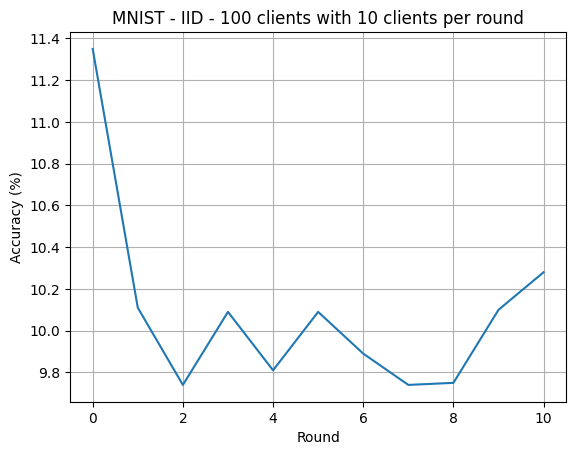

In [61]:
import matplotlib.pyplot as plt

print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]
round = [data[0] for data in global_accuracy_centralised]
acc = [100 * data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title("MNIST - IID - 100 clients with 10 clients per round")

In [ ]:
num_clients = 27
ids = [str(x) for x in range(num_clients)]
for id in ids:
    print(id)